# `elec-02`: Electrocorticography
In this lab, we'll examine a human electrocorticography (ECoG) dataset recorded while an epilepsy patient listened to a podcast. We'll preprocess and visualize the ECoG data, then perform an encoding analysis using word embeddings to capture linguistic content in the cortical activity. There are a couple additional packages you may need to install to run this lab: `pip install mat73 gensim`.

In [1]:
import os
import mne
import mat73
import numpy as np
import pandas as pd
import gensim.downloader as api
import matplotlib.pyplot as plt

from glob import glob
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr 
from nilearn.plotting import plot_markers
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Load data
First, we'll load in the ECoG data as an MNE `Raw` object. We'll focus on 64 electrodes from an 8 x 8 grid.

In [2]:
#sub_dir = '/jukebox/hasson/ariel/247/conversation_space/crude-conversations/Podcast/NY717_111_Part1_conversation1'
#loc_dir = '/jukebox/hasson/ariel/247/conversation_space/presentation_template/NY717_elec'
data_dir = '/jukebox/PNI-classes/students/NEU502/2023-NEU502B/ecog-data'

In [3]:
# Load ECoG data. NY717 has 200+ electrodes, but we'll look at the first 64
n_elecs = 65
ids = []
matfiles = []
for i in range(1, n_elecs):
    filepath = f'{data_dir}/NY717_111_Part1_conversation1_electrode_raw_file_{i}.mat'
    # filepath = f'{sub_dir}/preprocessed_all/NY717_111_Part1_conversation1_electrode_preprocess_file_{i}.mat'
    if os.path.isfile(filepath):
        ids.append(i-1)
        matfiles.append(loadmat(filepath)['electrode_data'])
        # matfiles.append(loadmat(filepath)['p1st'])
ecog = np.stack(matfiles).squeeze()
ecog.shape

(64, 921601)

Next, we'll load in the MNI coordinates for these electrodes, so we know roughly where these electrodes fall in a standard brain space.

In [4]:
# Load MNI coordinate for all available electrodes

# Electrode names in EDF do not match names in coordinate file,
# so we need this function
def remove_leading_zeros(string):
    newstr = []
    found = False
    for s in string:
        if s.isnumeric():
            if not found and int(s) == 0:
                continue
            else:
                newstr.append(s)
                found = True
        else:
            newstr.append(s)
    return ''.join(newstr)

mnifile = 'NY717_030519_coor_MNI_LH_2019-03-11.txt'
locdf = pd.read_csv(data_dir + '/' + mnifile, header=None, sep=' ', names=('name', 'x', 'y', 'z', 't', 'nil'))
locdf['name'] = locdf.name.apply(remove_leading_zeros)
locdf

,name,x,y,z,t,nil
0,LGA1,-52.000000,48.000000,17.000000,G,NaN
1,LGA2,-54.000000,40.000000,23.000000,G,NaN
2,LGA3,-57.000000,31.000000,30.000000,G,NaN
3,LGA4,-59.000000,22.666667,34.666667,G,NaN
4,LGA5,-59.333333,13.000000,39.333333,G,NaN
...,...,...,...,...,...,...
209,DLPMT4,-33.333333,-25.000000,-14.666667,D,NaN
210,DLPMT5,-37.000000,-20.000000,-15.000000,D,NaN
211,DLPMT6,-41.333333,-15.333333,-16.000000,D,NaN
212,DLPMT7,-45.142857,-10.857143,-16.571429,D,NaN


In [5]:
# Load header file and merge it with the coordinate file
headfile = glob(data_dir + '/*_header.mat')[0]
header = mat73.loadmat(headfile)
elec_names = header['header']['label']
edf_hd = pd.DataFrame(elec_names, columns=('name',))

# Merge
elec_locs = pd.merge(edf_hd, locdf, on='name', how='left')
print(len(edf_hd), len(elec_locs))
elec_locs = elec_locs.iloc[ids]
elec_locs

264 264


,name,x,y,z,t,nil
0,LGA1,-52.000000,48.000000,17.000000,G,NaN
1,LGA2,-54.000000,40.000000,23.000000,G,NaN
2,LGA3,-57.000000,31.000000,30.000000,G,NaN
3,LGA4,-59.000000,22.666667,34.666667,G,NaN
4,LGA5,-59.333333,13.000000,39.333333,G,NaN
...,...,...,...,...,...,...
59,LGA60,-62.285714,-5.142857,-34.857143,G,NaN
60,LGA61,-66.800000,-13.600000,-30.800000,G,NaN
61,LGA62,-69.333333,-24.000000,-27.333333,G,NaN
62,LGA63,-71.000000,-33.000000,-21.000000,G,NaN


In [6]:
# Create the Raw object
ch_names = elec_locs.name.tolist()
ch_types = ['ecog' if pd.notna(t) else 'misc' for t in elec_locs['t']]
info = mne.create_info(ch_names=ch_names,
                       ch_types=ch_types,
                       sfreq=512)
raw = mne.io.RawArray(ecog.squeeze(), info)

# Add electrode coordinates
locs = elec_locs.iloc[:, 1:4].values
montage = mne.channels.make_dig_montage(
        ch_pos=dict(zip(ch_names, locs)),
        coord_frame='mni_tal'
)
raw.set_montage(montage, on_missing='warn')

Creating RawArray with float64 data, n_channels=64, n_times=921601
    Range : 0 ... 921600 =      0.000 ...  1800.000 secs
Ready.


<ipython-input-6-7d55e9d332a8>:15: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing='warn')


<RawArray | 64 x 921601 (1800.0 s), ~450.1 MB, data loaded>

Next, we'll load in the time-locked text transcript for the podcast stimulus.

In [7]:
# Load podcast transcript
datum = glob(data_dir + '/NY717_111_Part1_conversation1_datum_conversation_trimmed.txt')[0]
datum = pd.read_csv(datum, sep=' ', header=None, names=['word', 'onset', 'offset', 'acc', 'speaker'])
datum['word'] = datum.word.str.lower()
datum = datum[~ datum.word.isin({'sp', '{lg}'})]
datum.drop_duplicates('onset', inplace=True)  # mne does not like duplicate events
# correct for preprocessed trimmed times
datum.onset += 3000
datum.offset += 3000
datum

,word,onset,offset,acc,speaker
0,so,3356.1457,3427.8257,1,Speaker2
1,there's,3438.0657,3519.9857,1,Speaker2
2,some,3509.7457,3591.6657,1,Speaker2
3,places,3601.9057,3740.1457,1,Speaker2
4,where,3770.8657,3822.0657,1,Speaker2
...,...,...,...,...,...
5899,it's,917626.0608,917677.2608,1,Speaker2
5900,a,917697.7408,917707.9808,1,Speaker2
5901,uniquely,917748.9408,917938.3808,1,Speaker2
5902,human,917969.1008,918097.1008,1,Speaker2


In [8]:
# Are we roughly the same length?
print(ecog.shape[1] / 512)
print(datum.offset.iloc[-1] / 512)

1800.001953125
1793.809025


In [9]:
# Add word onsets as annotations on the raw object
annotations = mne.Annotations(datum.onset.to_numpy() / 512,  # divide by sample_rate b/c has to be in seconds
                              (datum.offset - datum.onset).to_numpy() / 512,
                              description=datum.word.to_numpy())
raw = raw.set_annotations(annotations)

In [10]:
# Save
raw.save('sub-717_task-podcast_ieeg.fif', overwrite=True)
# raw = mne.io.read_raw('sub-717_task-podcast_ieeg.fif')

Overwriting existing file.
Writing /mnt/cup/labs/hasson/snastase/neu502b-2023/neu502b-lab/elec-02/sub-717_task-podcast_ieeg.fif


<ipython-input-10-8635bb5c766b>:2: RuntimeWarning: This filename (/mnt/cup/labs/hasson/snastase/neu502b-2023/neu502b-lab/elec-02/sub-717_task-podcast_ieeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save('sub-717_task-podcast_ieeg.fif', overwrite=True)


Closing /mnt/cup/labs/hasson/snastase/neu502b-2023/neu502b-lab/elec-02/sub-717_task-podcast_ieeg.fif
[done]


In [11]:
!ls -lh

total 546M
-rw-r--r--. 1 snastase g_hasson  490K Apr 17 12:54 elec-02-ecog.ipynb
-rw-r--r--. 1 snastase g_hasson  2.0K Apr 16 19:20 requirements.txt
-rw-r--r--. 1 snastase g_hasson 1009K Apr 16 19:20 setup_bkp.ipynb
-rw-r--r--. 1 snastase g_hasson  226M Apr 17 12:56 sub-717_task-podcast_desc-preprocessed_ieeg.fif
-rw-r--r--. 1 snastase g_hasson  226M Apr 17 12:56 sub-717_task-podcast_ieeg.fif


### Preprocessing the ECoG data
Next, we'll preprocess the ECoG data to mitigate line noise and focus on high-gamma broadband power.

Setting 174 of 921601 (0.02%) samples to NaN, retaining 921427 (99.98%) samples.
Effective window size : 4.000 (s)


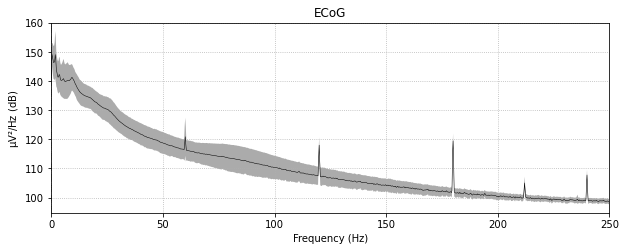

In [12]:
# Look at PSD

def add_arrows(axes):
    # add some arrows at 60 Hz and its harmonics
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (60, 120, 180, 240):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4):(idx + 5)].max()
            ax.arrow(x=freqs[idx], y=y + 18, dx=0, dy=-12, color='red',
                     width=0.1, head_width=3, length_includes_head=True)

fig = raw.plot_psd(fmax=250, average=True)
add_arrows(fig.axes)
plt.show()

In [13]:
# Perform common average referencing to remove noise artifacts on all electrodes
# An alternative is ICA
raw = raw.set_eeg_reference(ref_channels='average', ch_type='ecog')

Applying average reference.
Applying a custom ECoG reference.


In [14]:
# Notch filter power line noise
freqs = [60 * m for m in range(1, 4)]
print(freqs)
raw = raw.notch_filter(freqs=freqs, notch_widths=2)

[60, 120, 180]
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)



In [15]:
# Extract high-gamma band and take the envelope
raw = raw.filter(70, 200,
                 picks='data',
                 method='iir',
                 iir_params=dict(order=4, ftype='butter'))
raw = raw.apply_hilbert(envelope=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 70 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 70.00, 200.00 Hz: -6.02, -6.02 dB



In [16]:
# z-score for good measure
raw._data = zscore(raw._data, axis=1)

In [17]:
# Save preprocessed
raw.save('sub-717_task-podcast_desc-preprocessed_ieeg.fif', overwrite=True)
# raw = mne.io.read_raw('sub-717_task-podcast_desc-preprocessed_ieeg.fif')

Overwriting existing file.
Writing /mnt/cup/labs/hasson/snastase/neu502b-2023/neu502b-lab/elec-02/sub-717_task-podcast_desc-preprocessed_ieeg.fif


<ipython-input-17-c43f54c9782b>:2: RuntimeWarning: This filename (/mnt/cup/labs/hasson/snastase/neu502b-2023/neu502b-lab/elec-02/sub-717_task-podcast_desc-preprocessed_ieeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save('sub-717_task-podcast_desc-preprocessed_ieeg.fif', overwrite=True)


Closing /mnt/cup/labs/hasson/snastase/neu502b-2023/neu502b-lab/elec-02/sub-717_task-podcast_desc-preprocessed_ieeg.fif
[done]


### Plot electrodes

https://nilearn.github.io/stable/modules/generated/nilearn.plotting.plot_markers.html

In [18]:
node_coords = np.vstack([ch['loc'][:3] for ch in raw.info['chs']])
node_coords.shape

(64, 3)

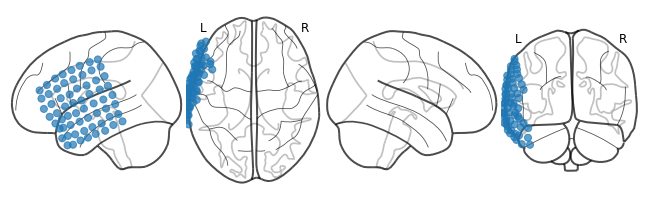

In [19]:
node_values = np.ones(len(node_coords)) * 0
plot_markers(node_values, node_coords,
             node_size=50, node_cmap='tab10',
             display_mode='lzry', colorbar=False)
plt.show()

### ERP analysis

In [20]:
# Here's a list of good electrodes
# Let me know if you need more, we have a full significant list here:
# https://docs.google.com/spreadsheets/d/1P2yNUHfivSNnGX3FFrrfNsiv0CddCVhxTy1FREfBzjI/edit?usp=sharing
# but the number in the name does not (always) correspond to the index number here
good_erp = [9, 18, 30, 31, 35, 36, 37, 38, 39, 45, 46, 61]

In [21]:
# Extract word onsets from the annotations
events, event_id = mne.events_from_annotations(raw, verbose=False)
events

array([[  3356,      0,    996],
       [  3438,      0,   1076],
       [  3510,      0,    999],
       ...,
       [917749,      0,   1143],
       [917969,      0,    545],
       [918128,      0,    197]])

In [22]:
# Convert events to epochs
epochs = mne.Epochs(raw,
                    events, event_id=event_id,
                    event_repeated='drop',  # make sure no two words have the same onset
                    tmin=-0.5, tmax=1.0,
                    picks='ecog',
                    detrend=None,
                    baseline=(None, 0))
epochs = epochs.load_data()

Not setting metadata
Not setting metadata
5111 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5111 events and 769 original time points ...
2 bad epochs dropped


Not setting metadata
Not setting metadata
5109 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


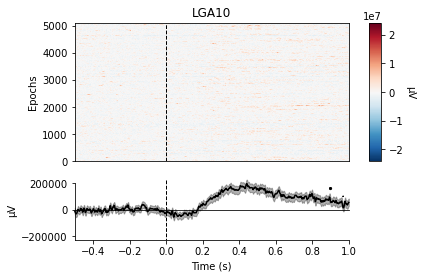

[<Figure size 432x288 with 4 Axes>]

In [23]:
# Plot average response for one electrode
# An alternative here would be to access the epoch data directly and
# manually plot: epochs._data[:, 9].mean()
epochs.plot_image(picks=[9])

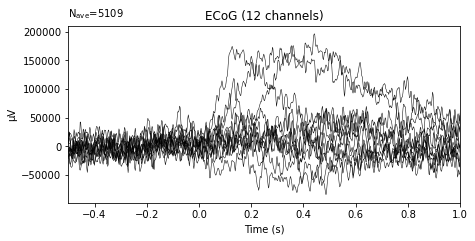

In [24]:
# Average epochs into an Evoked response based on our electrode list
# We get a mix of positive and negative ERPs
evoked = epochs.average(picks=good_erp)
evoked.plot();

### Linguistic encoding analysis
No built-in support in MNE as far as I know

In [25]:
# First we want to get word embeddings, so get events from the Raw annotations
events, event_id = mne.events_from_annotations(raw, verbose=False)
events

array([[  3356,      0,    996],
       [  3438,      0,   1076],
       [  3510,      0,    999],
       ...,
       [917749,      0,   1143],
       [917969,      0,    545],
       [918128,      0,    197]])

In [26]:
# get words from events
id2word = {value: key for key, value in event_id.items()}
words = [id2word[word_id] for word_id in events[:, 2]]
print(' '.join(words[:10]))

so there's some places where animals almost never go places


In [27]:
# Let's use gensim to get static word embeddings.
# What models can we use?
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [28]:
# Load in glove-50d
model = 'glove-wiki-gigaword-50'
model = api.load(model)

In [29]:
# Get word embeddings
new_words = []
embeddings = []
for i, word in enumerate(words):
    # Not all words are in glove (we're not using the glove tokenizer)
    # so keep track of words that have embeddings so we create epochs just
    # for them
    if word in model.key_to_index:
        embeddings.append(model.get_vector(word))
        new_words.append(i)

embeddings = np.vstack(embeddings)
embeddings.shape

(4906, 50)

In [30]:
# filter events to ones we have word embeddings for
events = events[new_words]
events.shape

(4906, 3)

In [31]:
# Let MNE create the epochs for us, but without any processing (e.g., baseline correction)
epochs = mne.Epochs(raw,
                    events, event_repeated='drop',
                    tmin=-0.5, tmax=1.0,
                    picks='ecog',
                    reject_by_annotation=None,  # mne drops any label with the word 'bad'..
                    detrend=None,
                    baseline=None)
epochs = epochs.load_data()

# Let's resample here so we don't have a lot of lags
epochs = epochs.resample(100)  # resample to 100 Hz

# Access data
data = epochs._data
data.shape  # words x electrodes x lags

Not setting metadata
Not setting metadata
4906 matching events found
No baseline correction applied
0 projection items activated
Loading data for 4906 events and 769 original time points ...
0 bad epochs dropped


(4906, 64, 150)

### Regression
Now we have ECoG in epochs and corresponding word embeddings

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

In [32]:
# Set up our design matrix and target variables (electrodes * lags)
n_words, n_elecs, n_lags = data.shape
X = embeddings
Y = data.reshape(n_words, -1)
X.shape, Y.shape

((4906, 50), (4906, 9600))

In [33]:
# we'll do a single train/test split without any shuffling to keep it contiguous
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

In [34]:
# Make a simple pipeline model
model = make_pipeline(StandardScaler(),
                      RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]))
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])))])

In [35]:
# Fit and get predictions
model = model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
Y_pred.shape

(1227, 9600)

In [36]:
# Let's evaluate the model. Compute correlation between predicted and actual neural signal
# per electrode and per lag
# (I have a vectorized version of this if you want, or can use himalaya.scoring.correlation_score)
n_targets = Y_train.shape[1]
scores = np.array([pearsonr(Y_test[:, i], Y_pred[:, i])[0] for i in range(n_targets)])
scores = scores.reshape(n_elecs, n_lags)
scores.shape

(64, 150)

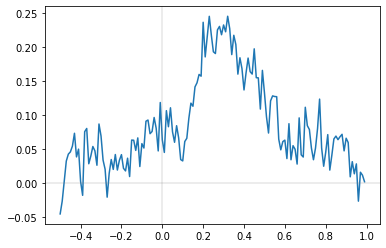

In [37]:
# Plot the correlation for one electrode on all lags
lags = epochs.times
fig, ax = plt.subplots()
ax.plot(lags, scores[9])
ax.axhline(0, color='gray', alpha=0.2)
ax.axvline(0, color='gray', alpha=0.2)
plt.show()

### Plot on brain

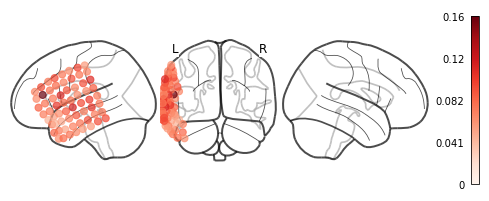

In [38]:
# Plot maximum correlation across lags for all electrodes
node_values = scores.max(-1)
vmax = np.quantile(scores.max(-1), .99)

plot_markers(node_values, node_coords,
             node_size=50, node_cmap='Reds', display_mode='lyr',
             node_vmin=0, node_vmax=vmax)
plt.show()